In [1]:
%config Completer.use_jedi=False
import numpy as np
import pandas as pd
import scipy.stats as sps
import math
from scipy.special import gamma
from scipy.optimize import bisect
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm.notebook import trange 
# from tqdm import trange
import time
import matplotlib.ticker as mtick

import mpmath as mp
mp.mp.dps = 50

In [2]:
mp.sqrt(1.4)

mpf('1.1832159566199231709810771399317754653170323447964647')

In [3]:
### Price of the Call/Put option with the Black Scholes model

def BlackScholesCallPut(S, K, T, sigma, r=0.0, call_put=1):
    d1 = (np.log(S/K) + (r+.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return call_put*(S*norm.cdf(call_put*d1) - K*np.exp (-r*T) * norm.cdf (call_put*d2))

#### Compute the implied volatility

def impliedVol(S, K, T, price, r=0.0, call_put=1):
    def smileMin(vol, *args):
        S, K, T, price, r, call_put = args
        return price - BlackScholesCallPut(S, K, T, vol, r, call_put)
    vMin = 0.0001
    vMax = 3.
    return bisect(smileMin, vMin, vMax, args=(S, K, T, price, r, call_put), rtol=1e-15, full_output=False, disp=True)

### Monte Carlo simulation

####  Quadratic rough Heston model
$$
\begin{aligned}
dS_t&=S_t\sqrt{V_t}dW_t \\
V_t&=a(Z_t-b)^2+c
\end{aligned}
$$
where $W$ is a Brownian motion and $a,\,b,\,c>0$. This model is of rought Heston type, in the sense that weighted past price returns are drivers of the volatility dynamics:
$$Z_t=\int_0^t(t-s)^{\alpha-1}\frac{\lambda}{\Gamma(\alpha)}(\theta_0(s)-Z_s)ds+\int_0^t(t-s)^{\alpha-1}\frac{\lambda}{\Gamma(\alpha)}\eta\sqrt{V_s}dW_s$$
with $\alpha\in(1/2,\,1),\,\lambda>0,\,\eta>0$ and $\theta_0$ a deterministic function.



For simplicity, $\theta_0(t)=\cfrac{Z_0}{\lambda\Gamma(1-\alpha)}t^{-\alpha}$, so we have
$$Z_t=Z_0-\int_0^t(t-s)^{\alpha-1}\frac{\lambda}{\Gamma(\alpha)}Z_sds+\int_0^t(t-s)^{\alpha-1}\frac{\lambda}{\Gamma(\alpha)}\eta\sqrt{V_s}dW_s$$

The parameters to calibrate are $v=(\alpha, \lambda, a,b,c, Z_0)\in\mathbb{R}^6$(Note that we can always take $\eta=1$ up to a rescaling of the other parameters).

In [4]:
import scipy.stats as st
st.sem(np.array([1, 2]))
?st.sem

In [49]:
class qrHeston:
    """
    A Monte Carlo class for simulating the stochastic models (ex: Heston, rough Heston...)
            
     
    """
    def __init__(self, qrheston_params, nbTimeSteps=200, Tmax=1., S0 = 100., r = 0.0):
        
        # Time discretisation parameters
        self.Tmax  = Tmax  
        self.nbTimeSteps  = nbTimeSteps
        self.dt = Tmax/nbTimeSteps
        self.time_grid = np.linspace(0., Tmax, nbTimeSteps + 1)
        
        # Spot price
        self.S0 = S0
        
        # risk-free interest
        self.r = r
        
        # qrHeston parameters
        self.alpha = qrheston_params['alpha']
        self.Lambda = qrheston_params['Lambda']
        self.a = qrheston_params['a']
        self.b = qrheston_params['b']
        self.c = qrheston_params['c']
        self.Z0 = qrheston_params['Z0']
        
    
    def qrHeston_stock(self):
        """
        Monte Carlo Simulation for the quadratic rough Heston model
        
        Output:
            Stock price at maturity T
            
        """
        dt = self.dt
        nbTimeSteps  = self.nbTimeSteps
        
        # Generate a Brownian Motion sequence
        W = np.random.normal(0, 1, nbTimeSteps)
        X, Z, V  = np.zeros((3, nbTimeSteps))
        
        X[0] = np.log(self.S0)
        Z[0] = self.Z0
        V[0] = self.a * (self.Z0 - self.b)**2 + self.c


        coef = self.Lambda/gamma(self.alpha)
        dtsqrt = np.sqrt(dt)

        for i in range(1, nbTimeSteps):
            
            ti   = np.power(self.time_grid[i] - self.time_grid[: i], self.alpha - 1)
            Zi   = Z[: i]
            Vi   = V[: i]
            Wi   = W[: i] * dtsqrt
            
            tmp = np.dot(ti, dt*Zi - np.sqrt(Vi)*Wi)
            Z[i] = self.Z0 - coef*tmp
#             Z[i] = self.Z0 - coef*dt*np.sum(ti*Zi) + coef*np.sum(ti*np.sqrt(Vi)*Wi)
            V[i] = self.a * (Z[i] - self.b)**2 + self.c
            X[i] = X[i-1] -0.5*V[i-1]*dt + np.sqrt(V[i-1])*dtsqrt*W[i]

        return np.exp(X)
    
    def qrHeston_paths(self, nbPaths):
        
        ### generate N paths of stock prices for the max maturity Tmax
        """
        Input:
            nbPaths: int, number of paths for the stock prices
        Output: 
            An 2-2 array with each row as a single path
        """
        
        paths = np.zeros((nbPaths, self.nbTimeSteps))
        
        for i in trange(nbPaths):
            paths[i] = self.qrHeston_stock()
            
        return paths
    
    def qrHeston_stockPaths(self, nbPaths):
        """
        Monte Carlo Simulation for the quadratic rough Heston model
        
        Output:
            Stock price at maturity T
            
        """
        dt = self.dt
        dtsqrt = np.sqrt(dt)
        nbTimeSteps  = self.nbTimeSteps
        
        # Generate a Brownian Motion sequence
        W = np.random.normal(0, dtsqrt, (nbPaths, nbTimeSteps))
        X, Z, V  = np.zeros((3, nbPaths, nbTimeSteps))
        unit = np.ones(nbPaths)
        
        X[:, 0] = np.log(self.S0) * unit
        Z[:, 0] = self.Z0 * unit
        V[:, 0] = (self.a * (self.Z0 - self.b)**2 + self.c) * unit


        coef = self.Lambda/gamma(self.alpha)

        for i in trange(1, nbTimeSteps):
            
            ti   = np.power(self.time_grid[i] - self.time_grid[: i], self.alpha - 1)
            Zi   = Z[:, : i]
            Vi   = V[:, : i]
            Wi   = W[:, : i] 
            
            tmp = np.dot(dt*Zi - np.sqrt(Vi)*Wi, ti)
            Z[:, i] = self.Z0 * unit - coef*tmp
#             Z[i] = self.Z0 - coef*dt*np.sum(ti*Zi) + coef*np.sum(ti*np.sqrt(Vi)*Wi)
            V[:, i] = self.a * (Z[:, i] - self.b)**2 + self.c
            X[:, i] = X[:, i-1] -0.5*V[:, i-1]*dt + np.sqrt(V[:, i-1])*W[:, i]

        return np.exp(X)
    
    def compute_relative_errors(self, sample):
        """
        Compute relative errors using 95% confidence intervals
        """
        avg = np.mean(sample)
        sig= np.std(sample)/np.sqrt(len(sample))
        
        f = np.array(list(filter(lambda x: x!=0 and x >= avg-1.96*sig and x <= avg+1.96*sig, sample)))
#         print(f)
        relative_errors = np.abs(f - avg)/f
        return 100*np.mean(relative_errors), 100*np.std(relative_errors), 100*np.max(relative_errors)
            
            
    def qrHeston_CallPut(self, strikes, maturities, N = 100000, call_put = 1):
        ### Compute the call/put option price with call_put = 1/-1 for "Call/Put"  for given strikes and maturities
        """
        Output:
            A list with each element the call/put prices for the strike(s) and maturity(maturities)
            Average, standard deviation and maximum relative errors of the Monte Carlo for each maturity-strike
        """
        dim = len(strikes)*len(maturities)
        
        callput_prices = np.zeros(dim)
        errors = np.zeros((3, dim))
        
        paths = self.qrHeston_stockPaths(N)
        
        i = 0
        for T in maturities:
           
            stop = int(T//self.dt) ##+1?
            Stocks = paths[:, stop]
            
            for K in strikes:
                tmp   = np.maximum(call_put*(Stocks - K), 0.0)
                
                callput_prices[i] = np.mean(tmp)
                
                errors[:, i] = self.compute_relative_errors(tmp)
                i += 1
                
        return callput_prices, errors

In [56]:
S0 = 100
nbTimeSteps = 100
r = 0.0
maturities = np.round(np.linspace(0.1, 2, 8), 2) # Time to expiry in years
strikes = [85, 90, 95, 97, 99, 100, 101, 102, 103, 104]
# strikes = [90,95, 97, 99, 100,101, 102, 103]

#### Parameters for quadratic rough Heston


Z0 = 0.1
alpha = 0.6
a = 0.384
b = 0.095
c = 0.0025
Lambda = 1.2

qrheston_params = {'S0': S0, 'alpha': alpha, 'Lambda': Lambda, 'a': a, 'b': b, 'c': c, 'Z0': Z0}

In [57]:
MC = qrHeston(qrheston_params, Tmax=maturities[-1])
MC.compute_relative_errors([0,1,2,3])

(37.5, 12.5, 50.0)

In [58]:
MC = qrHeston(qrheston_params, Tmax=maturities[-1])
call_prices, errors = MC.qrHeston_CallPut(strikes, maturities)

  0%|          | 0/199 [00:00<?, ?it/s]

Text(0, 0.5, 'Maturity')

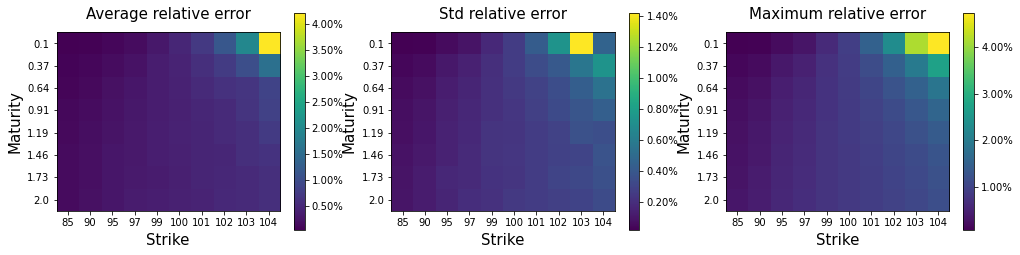

In [59]:
strikes_dim=len(strikes)
maturities_dim=len(maturities)

plt.figure(1,figsize=(17,4))
ax=plt.subplot(1,3,1)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(errors[0].reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,2)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(errors[1].reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,3)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(errors[2].reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

8


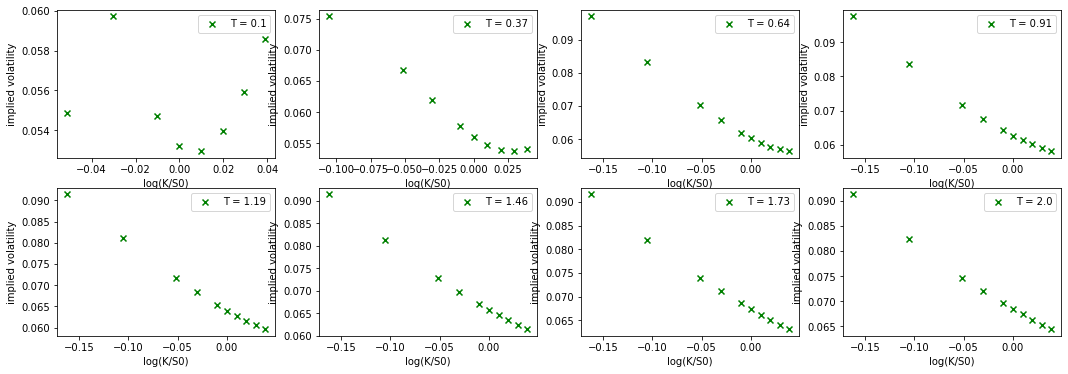

In [63]:
# call_prices
axisX = []
axisY = []

for i in range(maturities_dim):
    x = []
    y = []
    for j in range(strikes_dim):
        try:
            y.append(impliedVol(S0, strikes[j], maturities[i], call_prices[i*strikes_dim + j]))
            x.append(np.log(strikes[j]/S0))
        except:
            pass
    axisX.append(x)
    axisY.append(y)
    
print(len(axisX)) 
f = plt.figure(1, figsize=(18, 6))
for i in range(len(maturities)):
    plt.subplot(2, 4, i+1)
    plt.scatter(axisX[i], axisY[i], c='g', marker='x', label="T = %s"%maturities[i])
    plt.xlabel("log(K/S0)")
    plt.ylabel("implied volatility")
    plt.legend(loc=1)
plt.show();

In [ ]:
# call_prices
xs = []
ys = []
for i in range(len(maturities)):
    x = []
    y = []
    for j in range(len(strikes)):
        try:
            impVols = impliedVol(S0, strikes[j], maturities[i], call_prices[i*j: i])
            x.append(np.log(strikes[j]/S0))
            y.append(impVols)
        except:
            pass
    xs.append(x)
    ys.append(y)
    
    
f = plt.figure(1, figsize=(18, 6))
for i in range(len(maturities)):
    plt.subplot(2, 4, i+1)
    plt.scatter(xs[i],ys[i], c='g', marker='x', label="T = %s"%maturities[i])
    plt.xlabel("log(K/S0)")
    plt.ylabel("implied volatility")
    plt.legend(loc=1)
plt.show();


In [ ]:
np.max([[2, 3, 4], [1, 5, 2], [2, 4, 6]], axis=0)
# np.max?

In [ ]:
call_prices
impliedVol(S0, strikes[1], maturities[1], call_prices[1][1])

In [ ]:
idx = np.where(ivs>0)
plt.scatter(logmoneyness[idx], ivs[idx], c='g', marker='x', label=f"T = 0.1")
plt.xlabel("k (logmoneyness: ln(K/S))")
plt.ylabel("implied volatility")
plt.legend()
plt.show()

In [ ]:
# time = np.arange(N)
# f = plt.figure(figsize=(16,4))
# ax1 = plt.subplot(121)
# ax1.plot(time, S, label = "qrHeston")
# ax1.grid()
# ax1.set_xlabel("time")
# ax1.set_ylabel("Prices")
# ax1.legend(loc=1)

# ax2 = plt.subplot(122)
# ax2.plot(time, iv, label = "qrHeston")
# ax2.grid()
# ax2.set_xlabel("time")
# ax2.set_ylabel("implied volatility")
# ax2.legend(loc=1)
# plt.show()


In [ ]:
import multiprocessing

multiprocessing.cpu_count()

In [ ]:
import numpy as np
np.array([[1,2], [3,4]]).ravel()

In [ ]:
np.array([[i + j for j in range(3)] for i in range(2)]).ravel()

In [ ]:
a = np.array([1,2])
b = np.array([3,4])
c = np.array([4,5])
np.vstack((a, b, c))
